In [1]:
!pip install keras
!pip install tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

Using TensorFlow backend
we are currently using tensorflow version 2.14.0


In [2]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=20
stopper=EarlyStopping(patience=5)

In [3]:
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='E:\ml\plant',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 2044 files belonging to 3 classes.


In [4]:
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Hispa', 'Tungro', 'leaf_blast']


In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

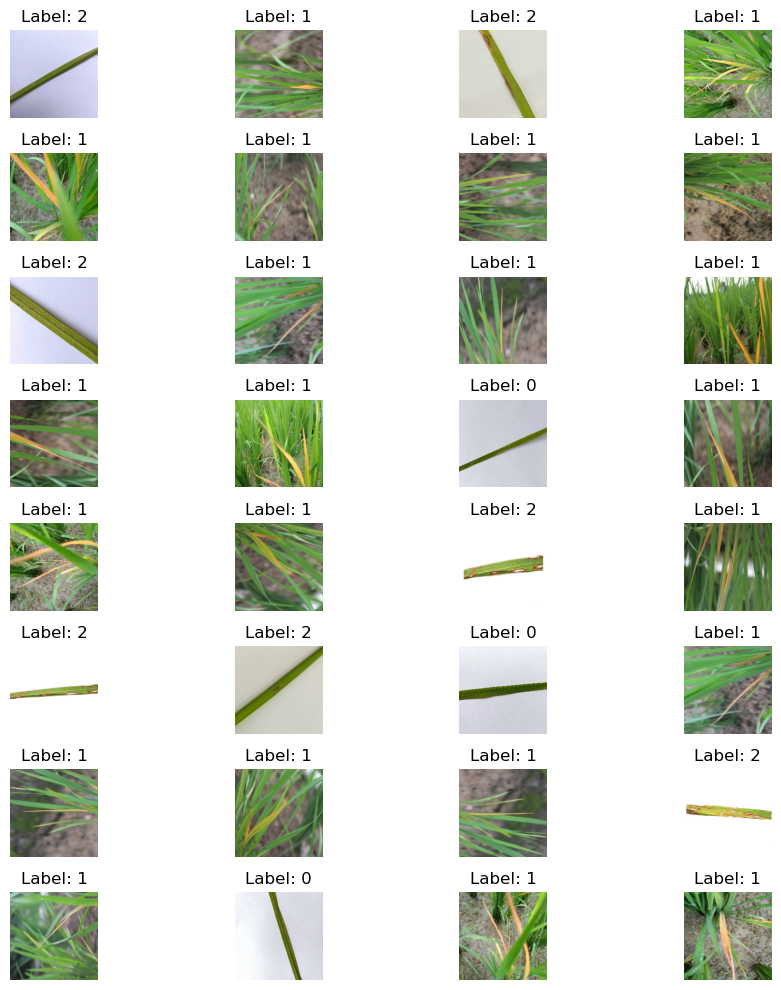

In [6]:
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

In [7]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [8]:
X= np.array(X)
y= np.array(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [10]:
X_train = X_train/255
X_test = X_test/255

In [11]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1533, 224, 224, 3)
shape of y_train: (1533,)
shape of X_test_scaled: (511, 224, 224, 3)
shape of y_test: (511,)


In [12]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

In [13]:
own_model = Sequential()

# adding first convloutional layer
own_model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape_3D))
own_model.add(MaxPooling2D())

# adding second convloutional layer
own_model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding third convloutional layer
own_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding flatten layer
own_model.add(Flatten())

# adding fully connected layers
own_model.add(Dense(200, activation='relu'))

#adding output layer : number of classes are 3
own_model.add(Dense(3, activation='softmax'))

In [14]:
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [15]:
own_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpointer_own = ModelCheckpoint(filepath='own_model.weights.best.hdf5', verbose=3, save_best_only=True)

history=own_model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs, callbacks=[checkpointer_own, stopper])

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7971
Epoch 1: val_loss improved from inf to 0.22431, saving model to own_model.weights.best.hdf5
48/48 [==============================] - 35s 686ms/step - loss: 0.5543 - accuracy: 0.7971 - val_loss: 0.2243 - val_accuracy: 0.9041
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.8839
Epoch 2: val_loss improved from 0.22431 to 0.18188, saving model to own_model.weights.best.hdf5
48/48 [==============================] - 34s 713ms/step - loss: 0.2191 - accuracy: 0.8839 - val_loss: 0.1819 - val_accuracy: 0.8982
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9041
Epoch 3: val_loss improved from 0.18188 to 0.16909, saving model to own_model.weights.best.hdf5
48/48 [==============================] - 34s 703ms/step - loss: 0.1915 - accuracy: 0.9041 - val_loss: 0.1691 - val_accuracy: 0.9335
Epoch 4/20
48/48 [====================

In [17]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

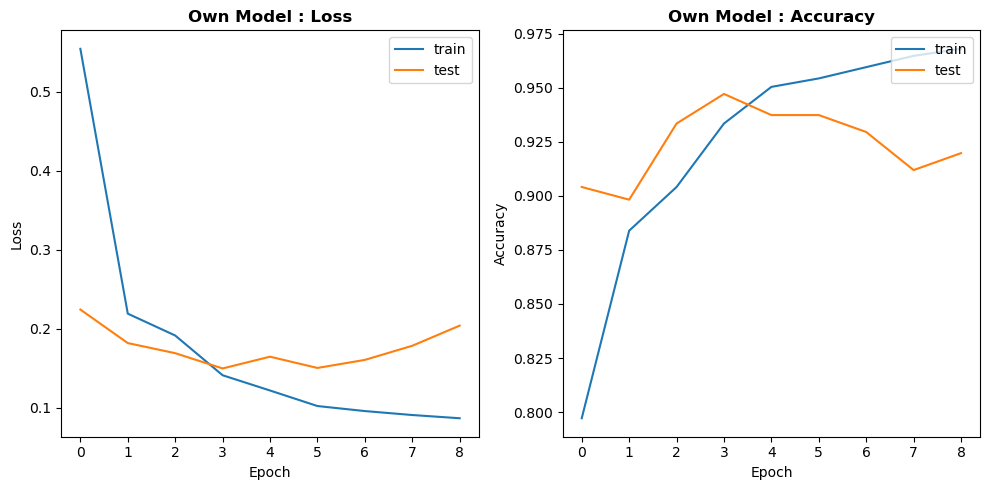

In [18]:
plot_performance(model_name= 'Own Model',
                 acc=history.history['accuracy'],
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'],
                 val_loss=history.history['val_loss'])

In [19]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [20]:
checkpointer_own_aug = ModelCheckpoint(filepath='own_model_aug.weights.best.hdf5', verbose=3, save_best_only=True)

aug_history= own_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[stopper, checkpointer_own_aug]
)

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.8821
Epoch 1: val_loss improved from inf to 0.17406, saving model to own_model_aug.weights.best.hdf5
47/47 [==============================] - 40s 838ms/step - loss: 0.2422 - accuracy: 0.8821 - val_loss: 0.1741 - val_accuracy: 0.9178
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9054
Epoch 2: val_loss improved from 0.17406 to 0.13367, saving model to own_model_aug.weights.best.hdf5
47/47 [==============================] - 38s 795ms/step - loss: 0.1884 - accuracy: 0.9054 - val_loss: 0.1337 - val_accuracy: 0.9393
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9127
Epoch 3: val_loss improved from 0.13367 to 0.12390, saving model to own_model_aug.weights.best.hdf5
47/47 [==============================] - 37s 785ms/step - loss: 0.1717 - accuracy: 0.9127 - val_loss: 0.1239 - val_accuracy: 0.9432
Epoch 4/20
47/47 [========

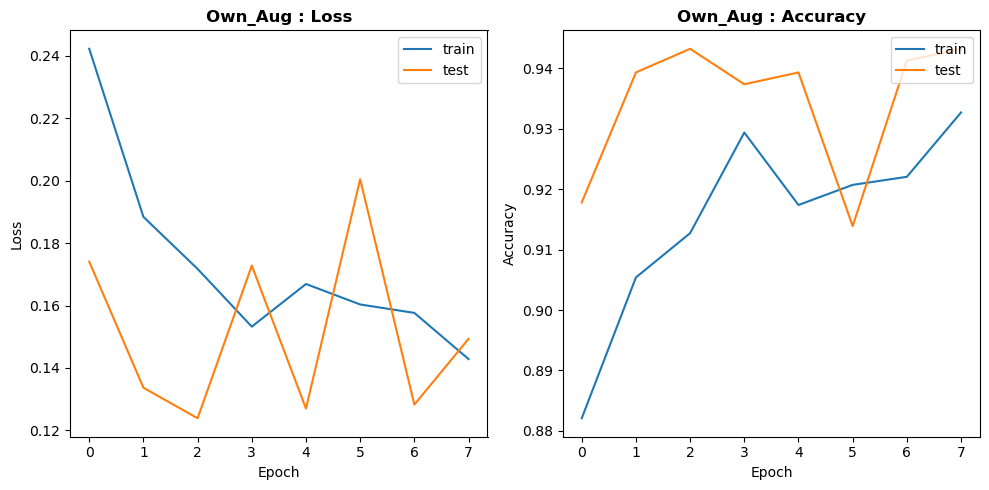

In [21]:
plot_performance(model_name='Own_Aug',
                  acc=aug_history.history['accuracy'],
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'],
                 val_loss=aug_history.history['val_loss'])

In [22]:
def build_model(hp):
  new_model=Sequential()

  # adding first convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
      kernel_size=hp.Choice('conv_1_kernel', values= [2,3]),
      padding=hp.Choice('conv_1_pad', values=['same', 'valid']),
      activation='relu', input_shape=input_shape_3D))
  new_model.add(MaxPooling2D())

  # adding second convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
      kernel_size=hp.Choice('conv_2_kernel', values= [2,3]),
      padding=hp.Choice('conv_2_pad', values=['same', 'valid']),
      activation='relu'))
  new_model.add(MaxPooling2D())

  # adding third convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
      kernel_size=hp.Choice('conv_3_kernel', values= [2,3]),
      padding=hp.Choice('conv_3_pad', values=['same', 'valid']),
      activation='relu'))
  new_model.add(MaxPooling2D())

  # adding flatten layer
  new_model.add(Flatten())
  new_model.add(Dense(
      units=hp.Int('dense_1_units', min_value=50, max_value=250, step=50),
      activation='relu'
      ))

  #adding output layer : number of classes are 3
  new_model.add(Dense(3, activation='softmax'))

  new_model.compile(
      optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return new_model  

In [23]:
tuner_search=RandomSearch(build_model, objective='val_accuracy', max_trials=3, directory='output', project_name='RiceLeafDisease')

Reloading Tuner from output\RiceLeafDisease\tuner0.json


In [24]:
tuner_search.search(
    datagen.flow(X_train, y_train),
    validation_data=(X_test, y_test),
    epochs=10
)

In [25]:
tuned_model=tuner_search.get_best_models(num_models=1)[0]

In [26]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 24)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 48)      4656      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 32)        13856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

In [27]:
checkpointer_own_tuned = ModelCheckpoint(filepath='own_model_tuned.weights.best.hdf5', verbose=3, save_best_only=True)

tuned_history= tuned_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    initial_epoch=10,
    epochs=epochs,
    callbacks=[stopper, checkpointer_own_tuned]
)

Epoch 11/20
47/47 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9234
Epoch 11: val_loss improved from inf to 0.14081, saving model to own_model_tuned.weights.best.hdf5
47/47 [==============================] - 38s 790ms/step - loss: 0.1621 - accuracy: 0.9234 - val_loss: 0.1408 - val_accuracy: 0.9276
Epoch 12/20
47/47 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9254
Epoch 12: val_loss improved from 0.14081 to 0.13624, saving model to own_model_tuned.weights.best.hdf5
47/47 [==============================] - 38s 812ms/step - loss: 0.1496 - accuracy: 0.9254 - val_loss: 0.1362 - val_accuracy: 0.9178
Epoch 13/20
47/47 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9300
Epoch 13: val_loss improved from 0.13624 to 0.11292, saving model to own_model_tuned.weights.best.hdf5
47/47 [==============================] - 38s 802ms/step - loss: 0.1433 - accuracy: 0.9300 - val_loss: 0.1129 - val_accuracy: 0.9472
Epoch 14/20
47